In [1]:
import torch, os, glob
import torch.nn as nn
import numpy as np
import tifffile as tiff
import umap
import matplotlib.pyplot as plt
from sklearn import manifold, datasets, metrics
import pandas as pd

def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
  continuous distributions IEEE International Symposium on Information
  Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

reducer = umap.UMAP()
gpu = True

# data_root = '/workspace/Data/womac4/full/'
# Change to your data root
data_root = '/home/ghc/Dataset/paired_images/womac4/full/'
# Change to your log root
#log_root = '/run/user/1000/gvfs/smb-share:server=changlab-nas.local,share=data/Data_GHC/OAI/contrastive_checkpoints/'
log_root = '/media/ExtHDD01/logs/womac4/'
# epoch
n_epoch = 160


In [2]:
df = pd.read_csv('env/csv/womac4_moaks.csv')
df = df.loc[df['V$$WOMKP#'] > 0, :]
df.reset_index(inplace=True)

## Models
## OPTION 1
#prj_name = '/global/1_project128/' # 0.90
#prj_name = '/global/1_project256_cosine/' #0.84
#prj_name = 'global1_cut1/nce4_down2_0011_ngf24_proj128/'
#prj_name = 'global1_cut1/nce4_down2_0011_ngf32_proj128_zcrop16/' # 0.88
#prj_name = 'global1_cut1/nce4_down2_0011_ngf24_proj128/' # 0.81
#prj_name = 'global1_cut1/nce4_down2_0011_ngf32_proj128_zcrop16_meanpool/' # bad
#prj_name = 'global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16/' # 0.92
#prj_name = 'global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16_moaks/' # 0.936
#prj_name = 'global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16_unpaired/' # 0.857
#prj_name = 'global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16_unpaired_nce0/' # 0.857
prj_name = 'global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16_unpaired_moaks/' # 0.914
force_no_projection = False # force to not use projection, or it will be used if .projection is in a model
use_eval = True

train_index = list(df.loc[df['READPRJ'].isnull(), :].index)[:]
test_index = list(df.loc[df['READPRJ'].notnull(), :].index)[:]

#train_index = range(667, 2225)
#test_index = range(667)
 
net = torch.load(log_root + prj_name + 'checkpoints/net_g_model_epoch_' + str(n_epoch)  +'.pth', map_location='cpu')
if use_eval:
    net = net.eval()

if gpu:
    net = net.cuda()
pool = nn.AdaptiveMaxPool3d(output_size=(1, 1, 1))
try:
    projection = net.projection.cpu()
    print('With projection')
except:
    projection = None
    print('No projection')
print('go')

With projection
go


In [3]:
alist = sorted(glob.glob(data_root + 'ap/*'))
blist = sorted(glob.glob(data_root + 'bp/*'))
print(len(alist))

51175


In [4]:
all = []
for i in range(2225):
    if (i % 100) == 0:
        print(i)
    ax = alist[i*23 : (i+1)*23]
    bx = blist[i*23 : (i+1)*23]
    ax = [tiff.imread(x) for x in ax]
    bx = [tiff.imread(x) for x in bx]
    ax = np.stack(ax, 0)
    bx = np.stack(bx, 0)
    ax = ax / ax.max()
    bx = bx / bx.max()
    ax = torch.from_numpy(ax).float()
    bx = torch.from_numpy(bx).float()
    ax = ax.unsqueeze(1)
    bx = bx.unsqueeze(1)
    if gpu:
        ax = ax.cuda()
    ax = net(ax, alpha=1, method='encode')[-1].detach().cpu()
    if gpu:
        bx = bx.cuda()
    bx = net(bx, alpha=1, method='encode')[-1].detach().cpu()
    ax = ax.permute(1, 2, 3, 0).unsqueeze(0)
    bx = bx.permute(1, 2, 3, 0).unsqueeze(0)
    if i <= -200:
        ax = ax.permute(4, 1, 2, 3, 0)
        ax = pool(ax)[:, :, 0, 0, 0]
        bx = bx.permute(4, 1, 2, 3, 0)
        bx = pool(bx)[:, :, 0, 0, 0]
    else:
        ax = pool(ax)[:, :, 0, 0, 0]
        bx = pool(bx)[:, :, 0, 0, 0]
    if (projection is not None) and (~force_no_projection):
        ax = projection(ax).detach().cpu()
        bx = projection(bx).detach().cpu()
    all.append(ax)
    all.append(bx)
    del ax
    del bx
all = torch.cat(all, 0)
all = all.numpy()
print(all.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
(4450, 32)


In [5]:
#np.save('f1.npy', all)
#all = np.load('f0.npy')
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


train_index = [2 * x for x in train_index] + [2 * x + 1 for x in train_index]
test_index = [2 * x for x in test_index] + [2 * x + 1 for x in test_index]

labels = np.array([-1, 1] * 2225)


# Split dataset into training and testing data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = all[train_index, :]
y_train = labels[train_index]
X_test = all[test_index, :]
y_test = labels[test_index]


# Create a SVM Classifier
clf = svm.SVC(kernel='poly', probability=True)  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Compute AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)


## torch
import torch
import torch.nn as nn
import torch.optim as optim

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)


# SVM Model
class LinearSVM(nn.Module):
    def __init__(self):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        return self.fc(x)

model = LinearSVM()

# Loss and Optimizer
def hinge_loss(output, target):
    return torch.mean(torch.clamp(1 - output.t() * target, min=0))

optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training Loop
for epoch in range(200):
    optimizer.zero_grad()
    output = model(X_train).squeeze()
    loss = hinge_loss(output, y_train)
    loss.backward()
    optimizer.step()

    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Testing the model (assuming you have X_test and Y_test)
with torch.no_grad():
     output = model(X_test).squeeze()
     print(output)
     prediction = torch.sign(output)
     accuracy = (prediction == y_test).float().mean()
     print(f'Accuracy: {accuracy.item()}')
     output = torch.sigmoid(model(X_train).squeeze())
     auc_score = roc_auc_score(y_train.detach().numpy(), output.detach().numpy())
     print(auc_score)
print('over')

Accuracy: 0.8373287671232876
AUC Score: 0.9147031572527679
tensor([-1.6952, -2.2942, -2.3257,  ...,  0.9297,  2.1257, -0.0457])
Accuracy: 0.835616409778595
0.8695512352755284
over


In [6]:
e0 = reducer.fit_transform(all)
e1 = manifold.TSNE(n_components=1, init='random', random_state=5, verbose=1).fit_transform(all)
e2 = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(all)
print(all.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4450 samples in 0.009s...
[t-SNE] Computed neighbors for 4450 samples in 0.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4450
[t-SNE] Computed conditional probabilities for sample 2000 / 4450
[t-SNE] Computed conditional probabilities for sample 3000 / 4450
[t-SNE] Computed conditional probabilities for sample 4000 / 4450
[t-SNE] Computed conditional probabilities for sample 4450 / 4450
[t-SNE] Mean sigma: 0.113932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.646652
[t-SNE] KL divergence after 1000 iterations: 1.479543
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4450 samples in 0.009s...
[t-SNE] Computed neighbors for 4450 samples in 0.216s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4450
[t-SNE] Computed conditional probabilities for sample 2000 / 4450
[t-SNE] Computed conditional probabilities for sample 3000 / 4450
[t-SNE] Computed conditional 

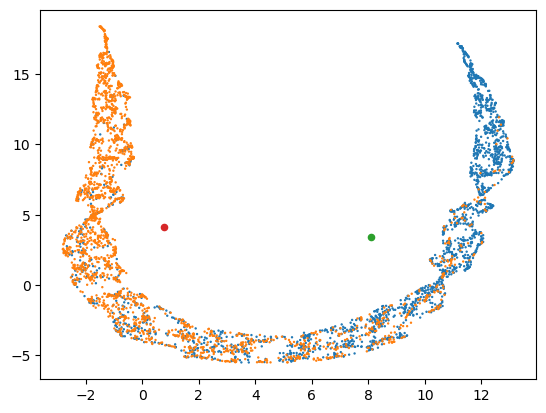

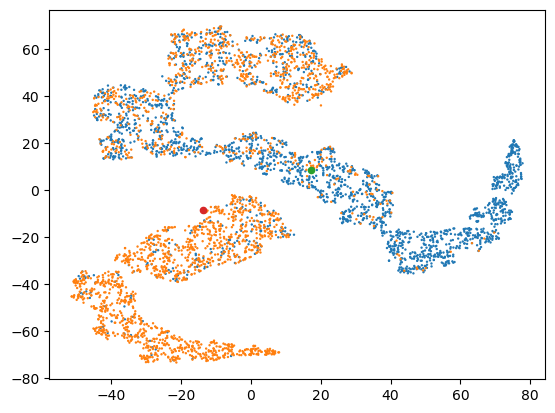

In [7]:
e = e0#[:23*5*2, :]
plt.scatter(e[::2, 0], e[::2, 1], s=0.5*np.ones(e.shape[0] // 2))
plt.scatter(e[1::2, 0], e[1::2, 1], s=0.5*np.ones(e.shape[0] // 2))
# I was trying to plot the center of group here but as you can see, it's not always meaningful
plt.scatter(e[::2, 0].mean(0), e[::2, 1].mean(0), s=20*np.ones(1))
plt.scatter(e[1::2, 0].mean(0), e[1::2, 1].mean(0), s=20*np.ones(1))
plt.show()
try:
    e = e2
    plt.scatter(e[::2, 0], e[::2, 1], s=0.5*np.ones(e.shape[0] // 2))
    plt.scatter(e[1::2, 0], e[1::2, 1], s=0.5*np.ones(e.shape[0] // 2))
    # I was trying to plot the center of group here but as you can see, it's not always meaningful
    plt.scatter(e[::2, 0].mean(0), e[::2, 1].mean(0), s=20*np.ones(1))
    plt.scatter(e[1::2, 0].mean(0), e[1::2, 1].mean(0), s=20*np.ones(1))
    plt.show()
except:
    e = e1
    plt.scatter(e[::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
    plt.scatter(e[1::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
    # I was trying to plot the center of group here but as you can see, it's not always meaningful
    plt.ylim(-5, 5)
    plt.show()
    

9.532285867292835
-inf
global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16_unpaired_moaks/
0.8534721373563944


/tmp/ipykernel_3042957/3128451374.py:54: RuntimeWarning: divide by zero encountered in true_divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


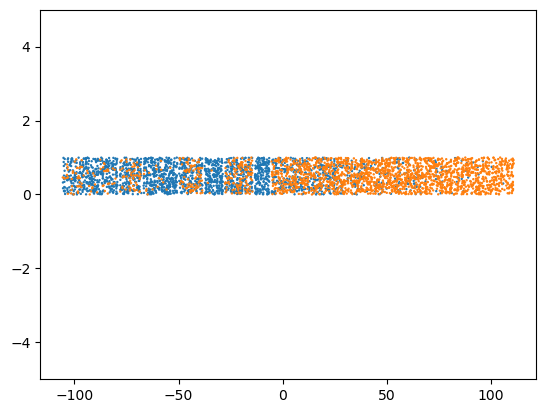

In [8]:
kl = KLdivergence(all[::2, :], all[1::2, :])
print(kl)
kl = KLdivergence(e1[::2, :], e1[1::2, :])
print(kl)
auc = metrics.roc_auc_score(np.concatenate([0 * np.ones(e1.shape[0] // 2), 1 * np.ones(e1.shape[0] // 2)]), np.concatenate([e1[::2, 0], e1[1::2, 0]]))
print(prj_name)
print(auc)
e = e1
plt.scatter(e[::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
plt.scatter(e[1::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
# I was trying to plot the center of group here but as you can see, it's not always meaningful
plt.ylim(-5, 5)
plt.show()

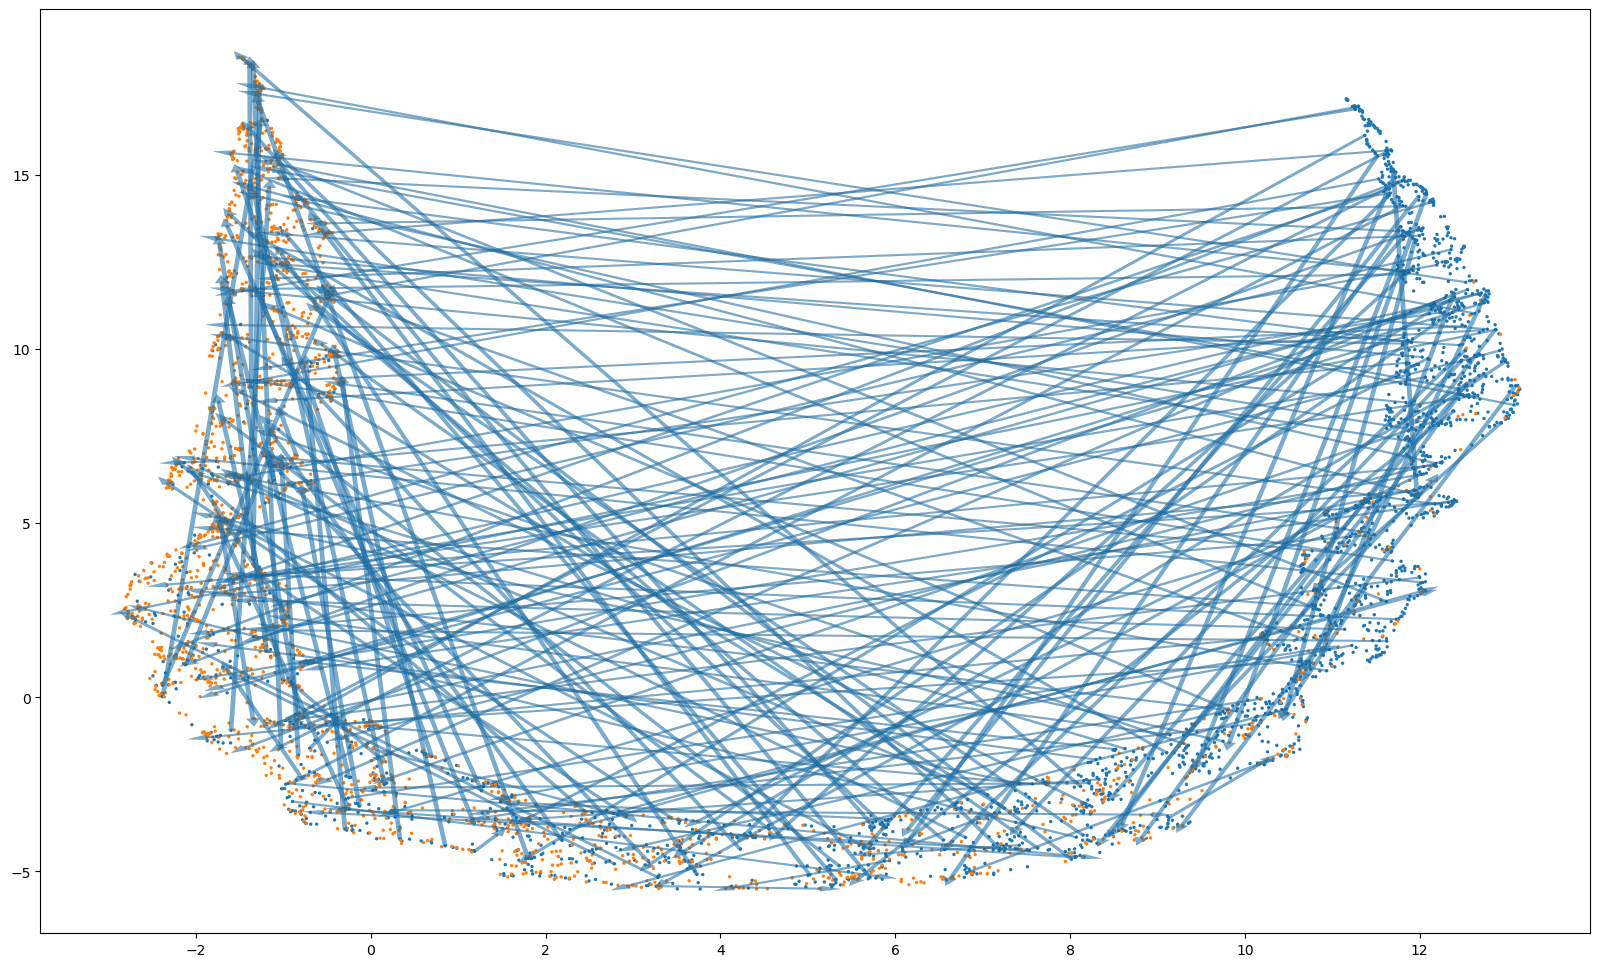

In [9]:
if 1:
    plt.figure(figsize=(20,12))
    e = e0
    eA = e[::2, :]
    eB = e[1::2, :]
    plt.scatter(e[::2, 0], e[::2, 1], s=2*np.ones(e.shape[0] // 2))
    plt.scatter(e[1::2, 0], e[1::2, 1], s=2*np.ones(e.shape[0] // 2))
    for i in range(200):
        plt.arrow(eA[i, 0], eA[i, 1], eB[i, 0] - eA[i, 0], eB[i, 1] - eA[i, 1], alpha=0.6, linewidth=0.1, width=0.05)
    plt.show()

## 